# Applying Classification Modeling
The goal of this week's assessment is to find the model which best predicts whether a person will default on their loan. In doing so, we want to utilize all of the different tools we have learned over the course: data cleaning, EDA, feature engineering/transformation, feature selection, hyperparameter tuning, and model evaluation. 

Dataset: The dataset comes customers default payments in Taiwan. More information about the dataset and columns are found in the link below.

https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients#


You will fit three different models (KNN, Logistic Regression, and Decision Tree Classifier) and use gridsearch to find the best hyperparameters for those models. Then you will compare the performance of those three models on a test set to find the best one.  


## Process/Expectations

#### You will be working in pairs for this assessment; please have ONE notebook and be prepared to explain how you worked in your pair.
1. Clean up your data set so that you can do EDA. This includes handling null values, categorical variables, removing unimportant columns, and removing outliers.
2. Perform EDA to identify opportunities to create new features.
    - [Great Example of EDA for classification](https://www.kaggle.com/stephaniestallworth/titanic-eda-classification-end-to-end) 
    - [Using Pairplots with Classification](https://towardsdatascience.com/visualizing-data-with-pair-plots-in-python-f228cf529166)
3. Create polynomial and/or interaction features. You must also create at least 2 new features that are not interactions or polynomial transformations. For example, you can create a new dummy variable that based on the value of a continuous variable (billamount6 >2000) or take the average of some past amounts.
4. Perform some feature selction. This can happen beforehand using F-scores, or you can do it as part of your model building process by looking at the weights of your regularized logistic regression or feature importance of your decision tree.  
5. You must fit each of the three models to your data and tune at least 1 hyperparameter per model. 
6. After identifying the best hyperparameters for each model, fit those models to the test set and identify the best model overall using the evaluation metric of your choice.
7. Present your best model.

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn
import seaborn as sns
import warnings
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

warnings.filterwarnings('once')


/Users/carymosley/opt/anaconda3/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


## 1. Data Cleaning

In [2]:
#read in the data
df = pd.read_csv('student_data.csv')
df.rename(columns={"default payment next month": "default"},inplace = True)

In [3]:
#checking the output, 78/22 split so I dont think we have to worry about a class imbalance
df['default'].value_counts()

0    18691
1     5308
Name: default, dtype: int64

In [4]:
df.shape

(23999, 25)

In [5]:
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,2873,350000,1,1,2,37,-2,-2,-2,-2,...,466,466,316,316,316,466,466,316,316,0
1,3598,50000,2,2,1,37,2,2,2,0,...,13026,13268,13497,5500,0,580,600,600,600,0
2,27623,50000,2,1,2,23,-1,-1,-1,-1,...,4800,9810,660,2548,2321,4800,9810,660,2980,0
3,6874,20000,1,3,1,56,0,0,0,0,...,13784,13420,13686,1508,1216,1116,0,490,658,0
4,6444,110000,2,2,2,32,0,0,0,0,...,108829,110557,106082,5400,5400,4100,4100,4100,4200,0


In [6]:
#No null values! Will look at the stats next
df.isnull().sum()

ID           0
LIMIT_BAL    0
SEX          0
EDUCATION    0
MARRIAGE     0
AGE          0
PAY_0        0
PAY_2        0
PAY_3        0
PAY_4        0
PAY_5        0
PAY_6        0
BILL_AMT1    0
BILL_AMT2    0
BILL_AMT3    0
BILL_AMT4    0
BILL_AMT5    0
BILL_AMT6    0
PAY_AMT1     0
PAY_AMT2     0
PAY_AMT3     0
PAY_AMT4     0
PAY_AMT5     0
PAY_AMT6     0
default      0
dtype: int64

In [7]:
df.dtypes

ID           int64
LIMIT_BAL    int64
SEX          int64
EDUCATION    int64
MARRIAGE     int64
AGE          int64
PAY_0        int64
PAY_2        int64
PAY_3        int64
PAY_4        int64
PAY_5        int64
PAY_6        int64
BILL_AMT1    int64
BILL_AMT2    int64
BILL_AMT3    int64
BILL_AMT4    int64
BILL_AMT5    int64
BILL_AMT6    int64
PAY_AMT1     int64
PAY_AMT2     int64
PAY_AMT3     int64
PAY_AMT4     int64
PAY_AMT5     int64
PAY_AMT6     int64
default      int64
dtype: object

In [8]:
#Dropping ID since we don't need to index them additionally
df = df.drop(columns = ['ID'],axis=1)

In [9]:
#SEX: Gender (1=male, 2=female)
df['SEX'].value_counts()


2    14486
1     9513
Name: SEX, dtype: int64

In [10]:
#SEX: 0 = female, 1 = male
df['SEX']=df['SEX'].apply(lambda x: 0 if x ==2 else x)
df['SEX'].value_counts()

0    14486
1     9513
Name: SEX, dtype: int64

In [11]:
df['EDUCATION'].value_counts()

2    11188
1     8442
3     3994
5      223
4      100
6       41
0       11
Name: EDUCATION, dtype: int64

In [12]:
#Education (1 = graduate school; 2 = university; 3 = high school; 4 = others).
#setting 0,4-6 to others
df['EDUCATION']=df['EDUCATION'].apply(lambda x: 0 if x >=4 else x)

df['EDUCATION'].value_counts()

2    11188
1     8442
3     3994
0      375
Name: EDUCATION, dtype: int64

In [13]:
df['MARRIAGE'].value_counts()

2    12735
1    10958
3      263
0       43
Name: MARRIAGE, dtype: int64

In [14]:
#MARRIAGE: Marital status (1=married, 2=single, 3=others)

df['MARRIAGE']=df['MARRIAGE'].apply(lambda x: 0 if x ==3 else x)
df['MARRIAGE'].value_counts()

2    12735
1    10958
0      306
Name: MARRIAGE, dtype: int64

Target Variable
default
0    18691
1     5308
Name: default, dtype: int64


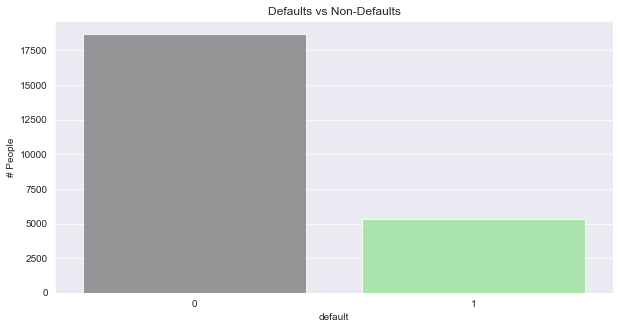

In [15]:
# Default Count
print('Target Variable')
print(df.groupby(['default']).default.count())

# Target Variable Countplot
sns.set_style('darkgrid')
plt.figure(figsize = (10,5))
sns.countplot(df['default'], alpha =.80, palette= ['grey','lightgreen'])
plt.title('Defaults vs Non-Defaults')
plt.ylabel('# People')
plt.show()

Continuous Variables
             count           mean            std       min      25%       50%  \
LIMIT_BAL  23999.0  167825.729405  129915.115993   10000.0  50000.0  140000.0   
AGE        23999.0      35.523230       9.253986      21.0     28.0      34.0   
BILL_AMT1  23999.0   51589.034710   74104.132627 -165580.0   3577.5   22472.0   
BILL_AMT2  23999.0   49521.698112   71551.215125  -67526.0   2958.0   21290.0   
BILL_AMT3  23999.0   47474.826368   70010.815328 -157264.0   2718.0   20223.0   
BILL_AMT4  23999.0   43796.589775   64927.450125 -170000.0   2392.5   19145.0   
BILL_AMT5  23999.0   40748.049169   61257.537699  -81334.0   1801.0   18227.0   
BILL_AMT6  23999.0   39226.852411   60075.536736 -339603.0   1280.0   17175.0   
PAY_AMT1   23999.0    5687.720113   16698.506577       0.0   1000.0    2110.0   
PAY_AMT2   23999.0    6019.571357   24541.362830       0.0    858.5    2012.0   
PAY_AMT3   23999.0    5253.322805   17967.028860       0.0    395.0    1809.0   
PAY_AMT

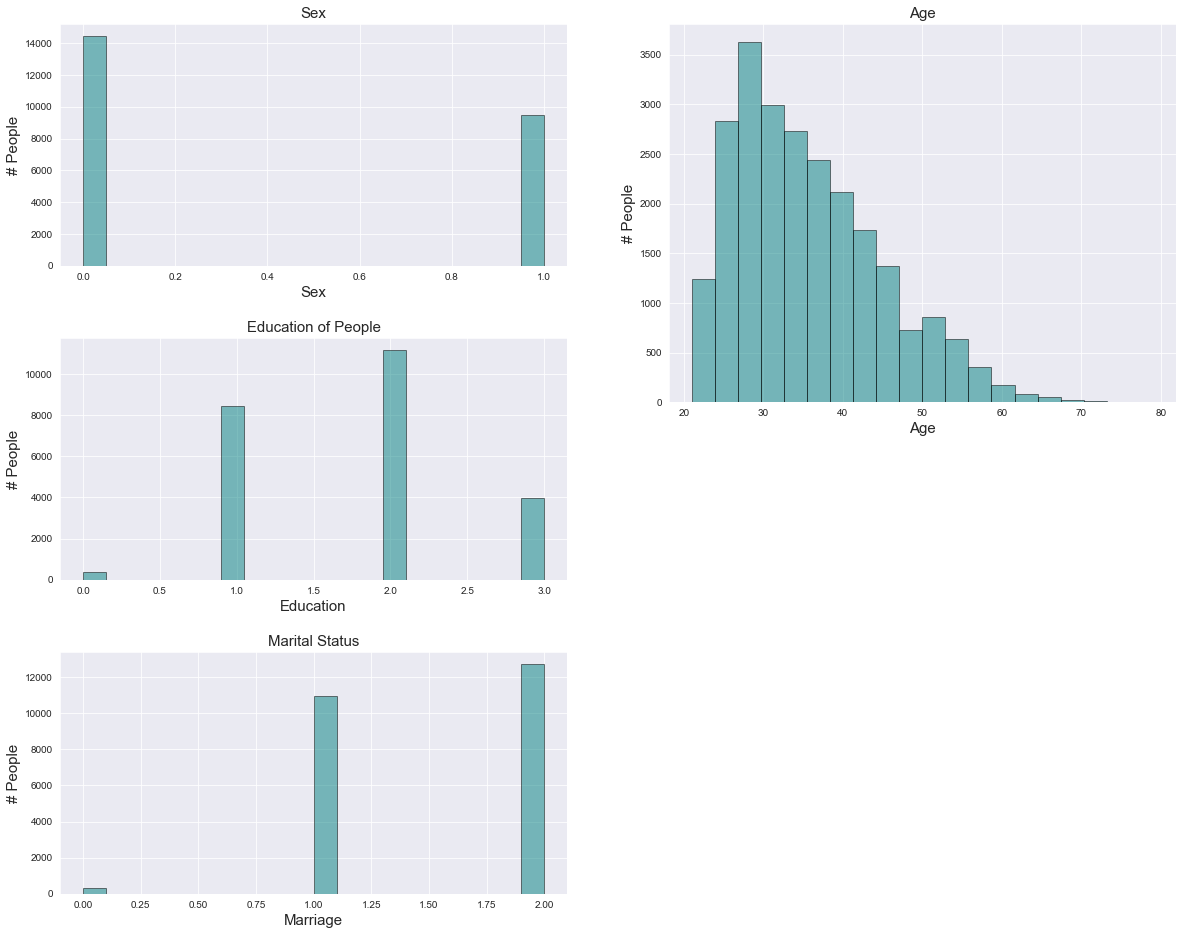

In [16]:
# Identify numeric features
print('Continuous Variables')
print(df[['LIMIT_BAL','AGE','BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6','PAY_AMT1'
         ,'PAY_AMT2','PAY_AMT3','PAY_AMT4','PAY_AMT5','PAY_AMT6']].describe().transpose())
print('--'*40)
print('Discrete Variables')
print(df.groupby('SEX').SEX.count())
print(df.groupby('EDUCATION').EDUCATION.count())
print(df.groupby('MARRIAGE').MARRIAGE.count())

   
# Subplots of Numeric Features
sns.set_style('darkgrid')
fig = plt.figure(figsize = (20,16))
fig.subplots_adjust(hspace = .30)

ax1 = fig.add_subplot(321)
ax1.hist(df['SEX'], bins = 20, alpha = .50,edgecolor= 'black',color ='teal')
ax1.set_xlabel('Sex', fontsize = 15)
ax1.set_ylabel('# People',fontsize = 15)
ax1.set_title('Sex',fontsize = 15)

ax2 = fig.add_subplot(323)
ax2.hist(df['EDUCATION'], bins = 20, alpha = .50,edgecolor= 'black',color ='teal')
ax2.set_xlabel('Education',fontsize = 15)
ax2.set_ylabel('# People',fontsize = 15)
ax2.set_title('Education of People',fontsize = 15)

ax3 = fig.add_subplot(325)
ax3.hist(df['MARRIAGE'], bins = 20, alpha = .50,edgecolor= 'black',color ='teal')
ax3.set_xlabel('Marriage',fontsize = 15)
ax3.set_ylabel('# People',fontsize = 15)
ax3.set_title('Marital Status',fontsize = 15)

ax4 = fig.add_subplot(222)
ax4.hist(df['AGE'], bins = 20, alpha = .50,edgecolor= 'black',color ='teal')
ax4.set_xlabel('Age', fontsize = 15)
ax4.set_ylabel('# People',fontsize = 15)
ax4.set_title('Age',fontsize = 15)

plt.show()

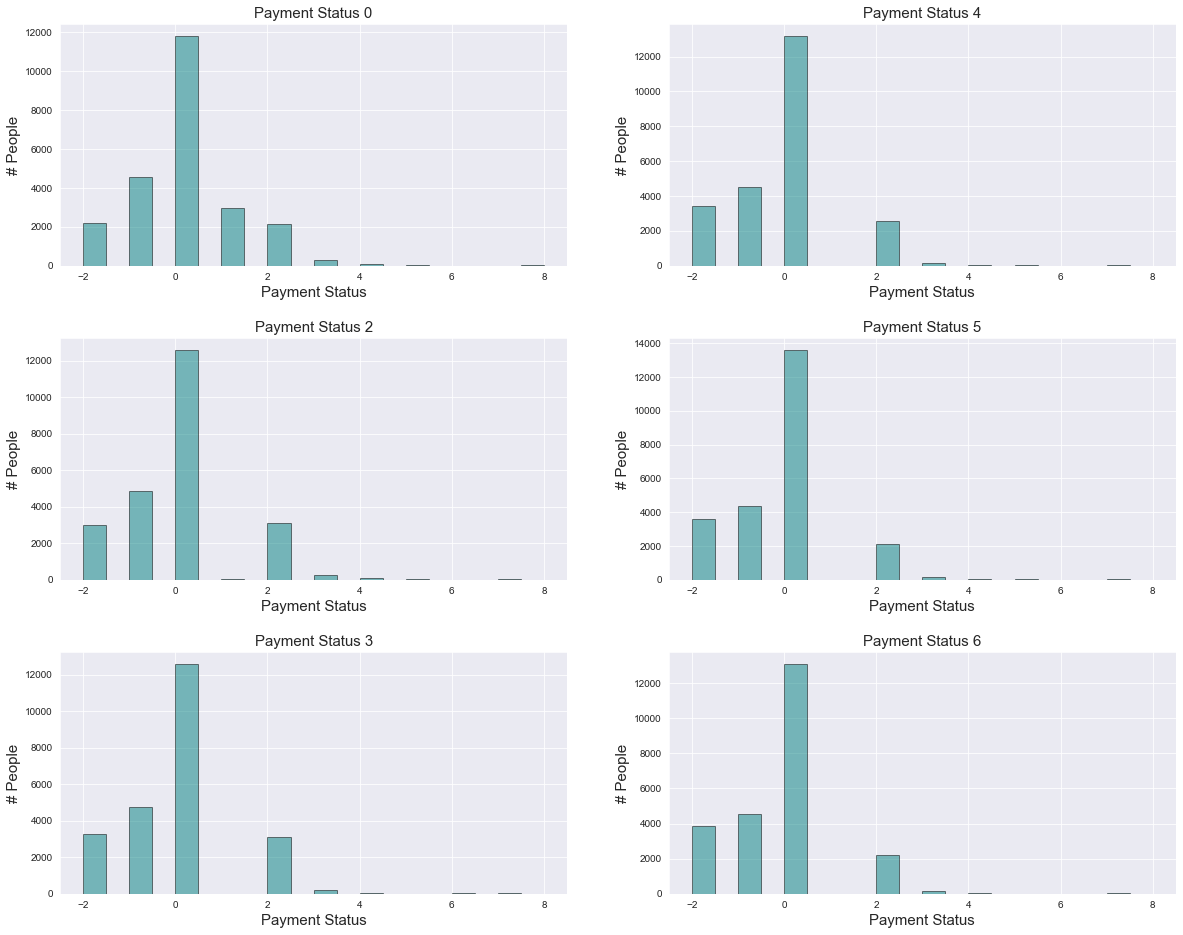

In [17]:
# Subplots of Numeric Features
sns.set_style('darkgrid')
fig = plt.figure(figsize = (20,16))
fig.subplots_adjust(hspace = .30)

ax1 = fig.add_subplot(321)
ax1.hist(df['PAY_0'], bins = 20, alpha = .50,edgecolor= 'black',color ='teal')
ax1.set_xlabel('Payment Status', fontsize = 15)
ax1.set_ylabel('# People',fontsize = 15)
ax1.set_title('Payment Status 0',fontsize = 15)

ax2 = fig.add_subplot(323)
ax2.hist(df['PAY_2'], bins = 20, alpha = .50,edgecolor= 'black',color ='teal')
ax2.set_xlabel('Payment Status', fontsize = 15)
ax2.set_ylabel('# People',fontsize = 15)
ax2.set_title('Payment Status 2',fontsize = 15)

ax3 = fig.add_subplot(325)
ax3.hist(df['PAY_3'], bins = 20, alpha = .50,edgecolor= 'black',color ='teal')
ax3.set_xlabel('Payment Status', fontsize = 15)
ax3.set_ylabel('# People',fontsize = 15)
ax3.set_title('Payment Status 3',fontsize = 15)

ax4 = fig.add_subplot(322)
ax4.hist(df['PAY_4'], bins = 20, alpha = .50,edgecolor= 'black',color ='teal')
ax4.set_xlabel('Payment Status', fontsize = 15)
ax4.set_ylabel('# People',fontsize = 15)
ax4.set_title('Payment Status 4',fontsize = 15)

ax5 = fig.add_subplot(324)
ax5.hist(df['PAY_5'], bins = 20, alpha = .50,edgecolor= 'black',color ='teal')
ax5.set_xlabel('Payment Status', fontsize = 15)
ax5.set_ylabel('# People',fontsize = 15)
ax5.set_title('Payment Status 5',fontsize = 15)

ax6 = fig.add_subplot(326)
ax6.hist(df['PAY_6'], bins = 20, alpha = .50,edgecolor= 'black',color ='teal')
ax6.set_xlabel('Payment Status', fontsize = 15)
ax6.set_ylabel('# People',fontsize = 15)
ax6.set_title('Payment Status 6',fontsize = 15)

plt.show()

Pay 0 Summary


default      0     1
PAY_0               
-2        1901   279
-1        3771   773
 0       10294  1541
 1        1966   976
 2         659  1461
 3          62   203
 4          18    44
 5          10    13
 6           3     3
 7           2     5
 8           5    10


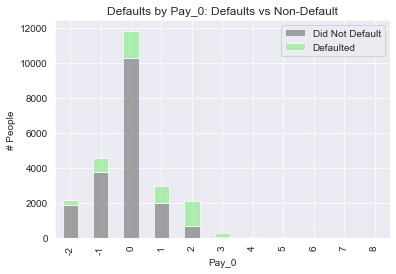

In [18]:

# Passenger class summary
print('Pay 0 Summary')

print('\n')
print(df.groupby(['PAY_0','default']).PAY_0.count().unstack())

# Passenger class visualization
pclass = df.groupby(['PAY_0','default']).PAY_0.count().unstack()
p1 = pclass.plot(kind = 'bar', stacked = True, 
                   title = 'Defaults by Pay_0: Defaults vs Non-Default', 
                   color = ['grey','lightgreen'], alpha = .70)
p1.set_xlabel('Pay_0')
p1.set_ylabel('# People')
p1.legend(['Did Not Default','Defaulted'])
plt.show()

Pay 2 Summary


default        0       1
PAY_2                   
-2        2471.0   535.0
-1        4062.0   789.0
 0       10590.0  2023.0
 1          18.0     1.0
 2        1400.0  1731.0
 3          99.0   159.0
 4          35.0    42.0
 5           7.0    11.0
 6           3.0     6.0
 7           5.0    11.0
 8           1.0     NaN


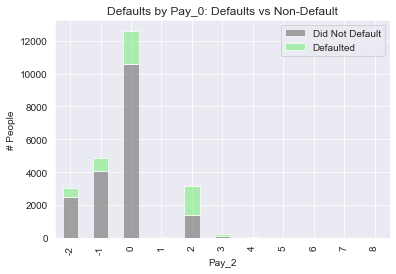

In [19]:

# Passenger class summary
print('Pay 2 Summary')

print('\n')
print(df.groupby(['PAY_2','default']).PAY_2.count().unstack())

# Passenger class visualization
pclass = df.groupby(['PAY_2','default']).PAY_2.count().unstack()
p1 = pclass.plot(kind = 'bar', stacked = True, 
                   title = 'Defaults by Pay_0: Defaults vs Non-Default', 
                   color = ['grey','lightgreen'], alpha = .70)
p1.set_xlabel('Pay_2')
p1.set_ylabel('# People')
p1.legend(['Did Not Default','Defaulted'])
plt.show()

Pay 3 Summary


default        0       1
PAY_3                   
-2        2659.0   587.0
-1        4025.0   751.0
 0       10397.0  2197.0
 1           3.0     NaN
 2        1488.0  1598.0
 3          77.0   104.0
 4          23.0    34.0
 5           7.0     8.0
 6           6.0    12.0
 7           5.0    15.0
 8           1.0     2.0


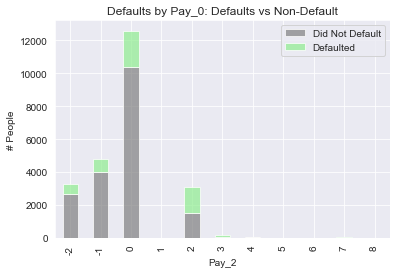

In [20]:

# Passenger class summary
print('Pay 3 Summary')

print('\n')
print(df.groupby(['PAY_3','default']).PAY_3.count().unstack())

# Passenger class visualization
pclass = df.groupby(['PAY_3','default']).PAY_3.count().unstack()
p1 = pclass.plot(kind = 'bar', stacked = True, 
                   title = 'Defaults by Pay_0: Defaults vs Non-Default', 
                   color = ['grey','lightgreen'], alpha = .70)
p1.set_xlabel('Pay_2')
p1.set_ylabel('# People')
p1.legend(['Did Not Default','Defaulted'])
plt.show()

Pay 4 Summary


default        0       1
PAY_4                   
-2        2801.0   652.0
-1        3798.0   725.0
 0       10791.0  2421.0
 1           1.0     NaN
 2        1205.0  1332.0
 3          51.0    84.0
 4          19.0    38.0
 5          11.0    16.0
 6           3.0     1.0
 7          10.0    38.0
 8           1.0     1.0


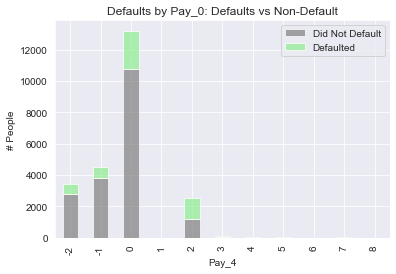

In [21]:

# Passenger class summary
print('Pay 4 Summary')

print('\n')
print(df.groupby(['PAY_4','default']).PAY_4.count().unstack())

# Passenger class visualization
pclass = df.groupby(['PAY_4','default']).PAY_4.count().unstack()
p1 = pclass.plot(kind = 'bar', stacked = True, 
                   title = 'Defaults by Pay_0: Defaults vs Non-Default', 
                   color = ['grey','lightgreen'], alpha = .70)
p1.set_xlabel('Pay_4')
p1.set_ylabel('# People')
p1.legend(['Did Not Default','Defaulted'])
plt.show()

Pay 5 Summary


default        0       1
PAY_5                   
-2        2915.0   702.0
-1        3668.0   706.0
 0       11038.0  2586.0
 2         978.0  1136.0
 3          50.0    88.0
 4          24.0    42.0
 5           7.0     8.0
 6           1.0     2.0
 7          10.0    37.0
 8           NaN     1.0


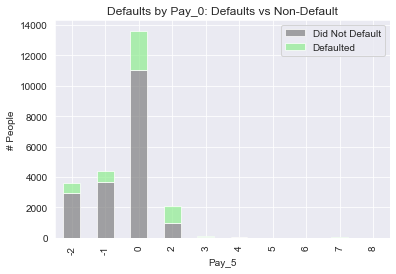

In [22]:

# Passenger class summary
print('Pay 5 Summary')

print('\n')
print(df.groupby(['PAY_5','default']).PAY_5.count().unstack())

# Passenger class visualization
pclass = df.groupby(['PAY_5','default']).PAY_5.count().unstack()
p1 = pclass.plot(kind = 'bar', stacked = True, 
                   title = 'Defaults by Pay_0: Defaults vs Non-Default', 
                   color = ['grey','lightgreen'], alpha = .70)
p1.set_xlabel('Pay_5')
p1.set_ylabel('# People')
p1.legend(['Did Not Default','Defaulted'])
plt.show()

Pay 6 Summary


default        0       1
PAY_6                   
-2        3111.0   767.0
-1        3774.0   786.0
 0       10628.0  2468.0
 2        1094.0  1117.0
 3          49.0    97.0
 4          16.0    26.0
 5           6.0     5.0
 6           5.0     9.0
 7           8.0    31.0
 8           NaN     2.0


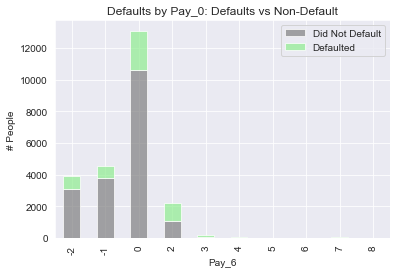

In [23]:

# Passenger class summary
print('Pay 6 Summary')

print('\n')
print(df.groupby(['PAY_6','default']).PAY_6.count().unstack())

# Passenger class visualization
pclass = df.groupby(['PAY_6','default']).PAY_6.count().unstack()
p1 = pclass.plot(kind = 'bar', stacked = True, 
                   title = 'Defaults by Pay_0: Defaults vs Non-Default', 
                   color = ['grey','lightgreen'], alpha = .70)
p1.set_xlabel('Pay_6')
p1.set_ylabel('# People')
p1.legend(['Did Not Default','Defaulted'])
plt.show()

Age Summary


default       0      1
AGE                   
21         39.0   12.0
22        325.0  142.0
23        537.0  189.0
24        657.0  232.0
25        702.0  236.0
26        797.0  208.0
27        948.0  259.0
28        911.0  229.0
29       1024.0  255.0
30        887.0  223.0
31        784.0  196.0
32        727.0  179.0
33        744.0  160.0
34        758.0  180.0
35        716.0  176.0
36        679.0  202.0
37        647.0  175.0
38        581.0  153.0
39        611.0  159.0
40        544.0  147.0
41        505.0  151.0
42        492.0  157.0
43        412.0  119.0
44        422.0  128.0
45        398.0   91.0
46        341.0  124.0
47        317.0  101.0
48        285.0   87.0
49        260.0   90.0
50        249.0   80.0
51        208.0   75.0
52        184.0   63.0
53        210.0   61.0
54        151.0   41.0
55        125.0   47.0
56        107.0   45.0
57         75.0   24.0
58         73.0   27.0
59         54.0   15.0
60         35.0   17.0
61         32.0   18

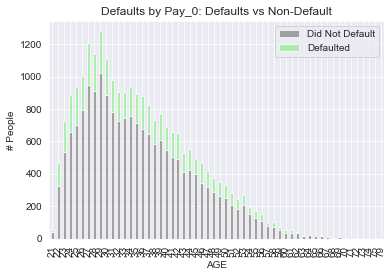

In [24]:

# Age summary
print('Age Summary')

print('\n')
print(df.groupby(['AGE','default']).AGE.count().unstack())

# Age visualization
pclass = df.groupby(['AGE','default']).AGE.count().unstack()
p1 = pclass.plot(kind = 'bar', stacked = True, 
                   title = 'Defaults by Pay_0: Defaults vs Non-Default', 
                   color = ['grey','lightgreen'], alpha = .70)
p1.set_xlabel('AGE')
p1.set_ylabel('# People')
p1.legend(['Did Not Default','Defaulted'])
plt.show()

In [25]:
#%defeault by age

test = df.groupby(['AGE','default']).AGE.count().unstack()[0]/(df.groupby(['AGE','default']).AGE.count().unstack()[0]+df.groupby(['AGE','default']).AGE.count().unstack()[1])
test.dropna(inplace=True)
test


AGE
21    0.764706
22    0.695931
23    0.739669
24    0.739033
25    0.748401
26    0.793035
27    0.785418
28    0.799123
29    0.800625
30    0.799099
31    0.800000
32    0.802428
33    0.823009
34    0.808102
35    0.802691
36    0.770715
37    0.787105
38    0.791553
39    0.793506
40    0.787265
41    0.769817
42    0.758089
43    0.775895
44    0.767273
45    0.813906
46    0.733333
47    0.758373
48    0.766129
49    0.742857
50    0.756839
51    0.734982
52    0.744939
53    0.774908
54    0.786458
55    0.726744
56    0.703947
57    0.757576
58    0.730000
59    0.782609
60    0.673077
61    0.640000
62    0.871795
63    0.782609
64    0.791667
66    0.681818
67    0.750000
68    0.800000
69    0.750000
70    0.833333
72    0.666667
75    0.666667
dtype: float64

Education Summary


default       0     1
EDUCATION            
0           351    24
1          6826  1616
2          8532  2656
3          2982  1012


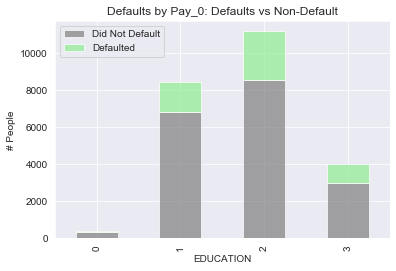

In [26]:

# Age summary
print('Education Summary')

print('\n')
print(df.groupby(['EDUCATION','default']).EDUCATION.count().unstack())

# Passenger class visualization
pclass = df.groupby(['EDUCATION','default']).EDUCATION.count().unstack()
p1 = pclass.plot(kind = 'bar', stacked = True, 
                   title = 'Defaults by Pay_0: Defaults vs Non-Default', 
                   color = ['grey','lightgreen'], alpha = .70)
p1.set_xlabel('EDUCATION')
p1.set_ylabel('# People')
p1.legend(['Did Not Default','Defaulted'])
plt.show()

Marriage Summary


default       0     1
MARRIAGE             
0           234    72
1          8399  2559
2         10058  2677


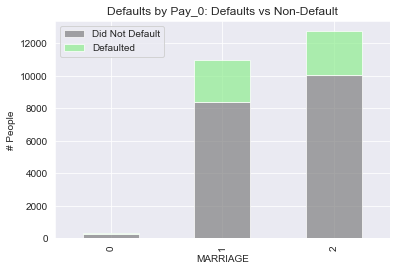

In [27]:
# Age summary
print('Marriage Summary')

print('\n')
print(df.groupby(['MARRIAGE','default']).MARRIAGE.count().unstack())

# Passenger class visualization
pclass = df.groupby(['MARRIAGE','default']).MARRIAGE.count().unstack()
p1 = pclass.plot(kind = 'bar', stacked = True, 
                   title = 'Defaults by Pay_0: Defaults vs Non-Default', 
                   color = ['grey','lightgreen'], alpha = .70)
p1.set_xlabel('MARRIAGE')
p1.set_ylabel('# People')
p1.legend(['Did Not Default','Defaulted'])
plt.show()

Balance Summary


default         0      1
LIMIT_BAL               
10000       238.0  157.0
16000         2.0    NaN
20000      1014.0  569.0
30000       824.0  467.0
40000        99.0   70.0
...           ...    ...
740000        1.0    1.0
750000        3.0    NaN
780000        1.0    NaN
800000        2.0    NaN
1000000       1.0    NaN

[80 rows x 2 columns]


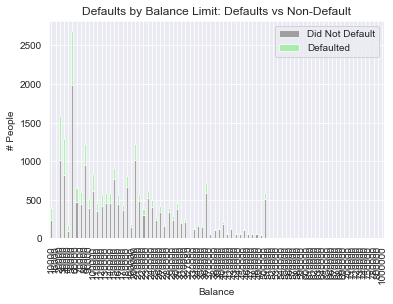

In [28]:
# Balance summary
print('Balance Summary')

print('\n')
print(df.groupby(['LIMIT_BAL','default']).LIMIT_BAL.count().unstack())

# Default visualization
pclass = df.groupby(['LIMIT_BAL','default']).LIMIT_BAL.count().unstack()
p1 = pclass.plot(kind = 'bar', stacked = True, 
                   title = 'Defaults by Balance Limit: Defaults vs Non-Default', 
                   color = ['grey','lightgreen'], alpha = .70)
p1.set_xlabel('Balance')
p1.set_ylabel('# People')
p1.legend(['Did Not Default','Defaulted'])
plt.show()

In [29]:
df.describe()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
count,23999.000000,23999.000000,23999.000000,23999.000000,23999.000000,23999.000000,23999.000000,23999.000000,23999.000000,23999.000000,...,23999.000000,23999.000000,23999.000000,23999.000000,2.399900e+04,23999.000000,23999.000000,23999.000000,23999.000000,23999.000000
mean,167825.729405,0.396392,1.783408,1.517897,35.523230,-0.014959,-0.134839,-0.165632,-0.217092,-0.261344,...,43796.589775,40748.049169,39226.852411,5687.720113,6.019571e+03,5253.322805,4824.490687,4825.033793,5245.642943,0.221176
std,129915.115993,0.489158,0.730617,0.524588,9.253986,1.120903,1.193044,1.193515,1.168719,1.133016,...,64927.450125,61257.537699,60075.536736,16698.506577,2.454136e+04,17967.028860,15730.753527,15596.580167,17795.775322,0.415047
min,10000.000000,0.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,0.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2392.500000,1801.000000,1280.000000,1000.000000,8.585000e+02,395.000000,300.000000,269.500000,125.000000,0.000000
50%,140000.000000,0.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,19145.000000,18227.000000,17175.000000,2110.000000,2.012000e+03,1809.000000,1500.000000,1500.000000,1500.000000,0.000000
75%,240000.000000,1.000000,2.000000,2.000000,42.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,55418.000000,50581.000000,49434.500000,5020.000000,5.000000e+03,4561.000000,4089.000000,4029.500000,4008.000000,0.000000
max,1000000.000000,1.000000,3.000000,2.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.000000,621000.000000,426529.000000,528666.000000,1.000000


## 2. EDA

## 3. Feature Engineering

In [30]:
df['Past_Payment'] = df['PAY_0']+df['PAY_2']+df['PAY_3']+df['PAY_4']+df['PAY_5']+df['PAY_6']
df['Past_Payment'].describe()

count    23999.000000
mean        -1.079712
std          5.886021
min        -12.000000
25%         -5.000000
50%          0.000000
75%          0.000000
max         36.000000
Name: Past_Payment, dtype: float64

In [31]:
#Creating column for billpayment over past 6 months
#0 if always on time
#1 if only ever missed a bill by one month once
#2 if misseed a total of 4 months(one month late 4 times or any combo)
#3 missed any amount of more than 4 months

df['Past_Payment']= df['Past_Payment'].apply(lambda x: 3 if x >=-7 else x)
df['Past_Payment']= df['Past_Payment'].apply(lambda x: 2 if (x >=-10) & (x<=-8) else x)
df['Past_Payment']= df['Past_Payment'].apply(lambda x: 1 if x ==-11 else x)
df['Past_Payment']= df['Past_Payment'].apply(lambda x: 0 if x ==-12 else x)

In [32]:
df['Past_Payment'].describe()

count    23999.000000
mean         2.730322
std          0.787080
min          0.000000
25%          3.000000
50%          3.000000
75%          3.000000
max          3.000000
Name: Past_Payment, dtype: float64

In [33]:
#Convert Pay 0 values
#0 if  on time
#1 if  one month late
#2 if 2 months or later 

In [34]:
df['PAY_0']= df['PAY_0'].apply(lambda x: 2 if x >=0 else x)
df['PAY_0']= df['PAY_0'].apply(lambda x: 1 if x ==-1 else x)
df['PAY_0']= df['PAY_0'].apply(lambda x: 0 if x ==-2 else x)
df['PAY_0'].describe()

count    23999.000000
mean         1.628985
std          0.644247
min          0.000000
25%          1.000000
50%          2.000000
75%          2.000000
max          2.000000
Name: PAY_0, dtype: float64

In [35]:
#binning ages: 21-25 = 0, 26-39 = 1, 40-59 = 2, 60+ = 3

df['Age_Bin'] = df['AGE'].apply(lambda x: 3 if x>=60 else x )
df['Age_Bin'] = df['Age_Bin'].apply(lambda x: 2 if x>=40 else x )
df['Age_Bin'] = df['Age_Bin'].apply(lambda x: 1 if x>=26 else x )
df['Age_Bin'] = df['Age_Bin'].apply(lambda x: 0 if x>=21 else x )
df['Age_Bin'].value_counts()

1    13568
2     7085
0     3071
3      275
Name: Age_Bin, dtype: int64

In [36]:
#Negative bill amounts
print(df['BILL_AMT1'][df['BILL_AMT1']<=0].count())
print(df['BILL_AMT2'][df['BILL_AMT2']<=0].count())
print(df['BILL_AMT3'][df['BILL_AMT3']<=0].count())
print(df['BILL_AMT4'][df['BILL_AMT4']<=0].count())
print(df['BILL_AMT5'][df['BILL_AMT5']<=0].count())
print(df['BILL_AMT6'][df['BILL_AMT6']<=0].count())
df['BILL_AMT1']= df['BILL_AMT1'].apply(lambda x: 0 if x <=0 else x)
df['BILL_AMT2']= df['BILL_AMT2'].apply(lambda x: 0 if x <=0 else x)
df['BILL_AMT3']= df['BILL_AMT3'].apply(lambda x: 0 if x <=0 else x)
df['BILL_AMT4']= df['BILL_AMT4'].apply(lambda x: 0 if x <=0 else x)
df['BILL_AMT5']= df['BILL_AMT5'].apply(lambda x: 0 if x <=0 else x)
df['BILL_AMT6']= df['BILL_AMT6'].apply(lambda x: 0 if x <=0 else x)


#First we tried to take the %paid each month and average this. However due to some people paying 0 
#paying months together this metric created some errors. Now summing the total bill and total
#payment amount
df['Bill_Total']=(df['BILL_AMT1']+df['BILL_AMT2']+df['BILL_AMT3']+df['BILL_AMT4']+df['BILL_AMT5']+df['BILL_AMT6'])
df['Pay_Total']=(df['PAY_AMT1']+df['PAY_AMT2']+df['PAY_AMT3']+df['PAY_AMT4']+df['PAY_AMT5']+df['PAY_AMT6'])
df['Pay_Percent']=df['Pay_Total']/df['Bill_Total']

print(df['Bill_Total'][df['Bill_Total']==0].count())

#going to drop anyhting where bill total over 6 months is 0
df.drop(df[df['Bill_Total'] == 0 ].index,inplace = True)
df.shape

2060
2540
2797
3065
3308
3734
780


(23219, 29)

In [37]:
df.drop(df[df['Pay_Percent'] > 1 ].index,inplace = True)
#binning Pay Percent: 100% = 0, 95%-99% = 1, 85%-94% = 2, <85% = 3

df['Pay_Percent_Bin'] = df['Pay_Percent'].apply(lambda x: 3 if x<.85 else x )
df['Pay_Percent_Bin'] = df['Pay_Percent_Bin'].apply(lambda x: 2 if (x>=.85)&(x<.95) else x )
df['Pay_Percent_Bin'] = df['Pay_Percent_Bin'].apply(lambda x: 0 if x == 1 else x )
df['Pay_Percent_Bin'] = df['Pay_Percent_Bin'].apply(lambda x: 1 if (x>=.95)&(x<1) else x )


Pay Percent Bin Summary


default              0     1
Pay_Percent_Bin             
0.0                389   112
1.0                454    48
2.0                719   135
3.0              14609  4395


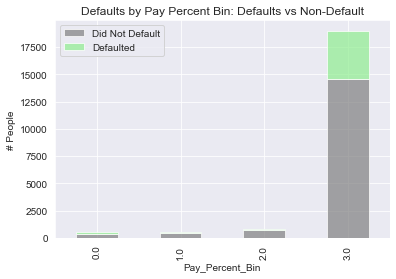

In [38]:
# Pay Percent Bin summary
print('Pay Percent Bin Summary')

print('\n')
print(df.groupby(['Pay_Percent_Bin','default']).Pay_Percent_Bin.count().unstack())

# Passenger class visualization
pclass = df.groupby(['Pay_Percent_Bin','default']).Pay_Percent_Bin.count().unstack()
p1 = pclass.plot(kind = 'bar', stacked = True, 
                   title = 'Defaults by Pay Percent Bin: Defaults vs Non-Default', 
                   color = ['grey','lightgreen'], alpha = .70)
p1.set_xlabel('Pay_Percent_Bin')
p1.set_ylabel('# People')
p1.legend(['Did Not Default','Defaulted'])
plt.show()

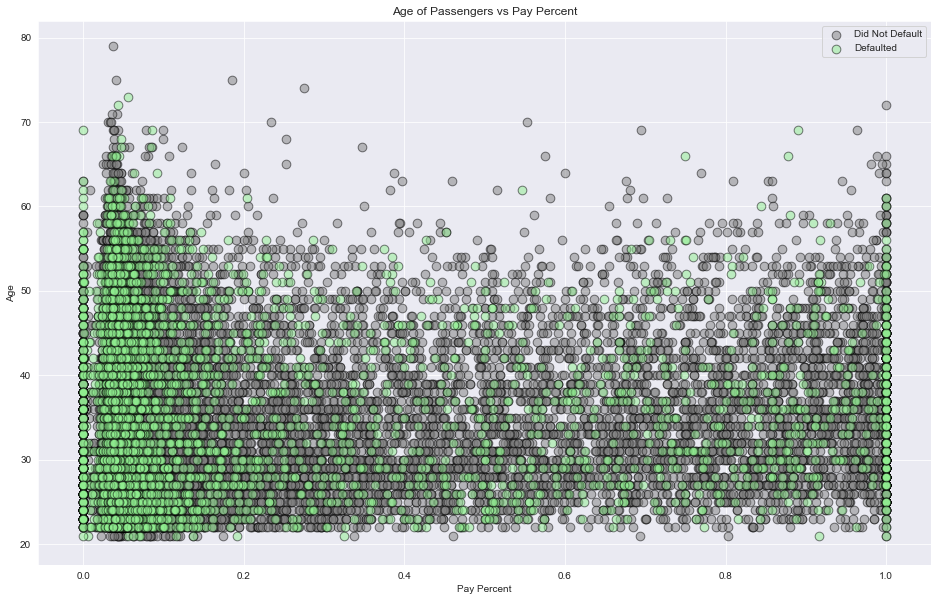

In [39]:
sns.set_style('darkgrid')
fig = plt.figure(figsize = (16,10))
fig.subplots_adjust(hspace = .30)
ax1 = fig.add_subplot(111)
ax1.scatter(x = df[df['default']==0].Pay_Percent, y = df[df['default']==0].AGE,
                        alpha = .50,edgecolor= 'black',  c = 'grey', s= 75, label = 'Did Not Default')
ax1.scatter(x = df[df['default']==1].Pay_Percent, y = df[df['default']==1].AGE,
                        alpha = .50,edgecolors= 'black',  c = 'lightgreen', s= 75, label = 'Defaulted')
ax1.set_xlabel('Pay Percent')
ax1.set_ylabel('Age')
ax1.set_title('Age of Passengers vs Pay Percent')
ax1.legend()

In [40]:
df['Balance_Percent'] = df['BILL_AMT1']/df['LIMIT_BAL']


In [41]:
df['Balance_Percent'].describe()

count    20861.000000
mean         0.486815
std          0.406865
min          0.000000
25%          0.070500
50%          0.455986
75%          0.880700
max          6.455300
Name: Balance_Percent, dtype: float64

In [42]:
#df.drop(columns = ['PAY_AMT1','PAY_AMT2','PAY_AMT3','PAY_AMT4','PAY_AMT5','PAY_AMT6','Pay_Total'],axis=1,inplace = True)



In [43]:
#df.drop(columns = ['BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6','Bill_Total'],axis=1,inplace = True)



In [44]:
#df.drop(columns = ['PAY_2','PAY_3','PAY_4','PAY_5','PAY_6'],axis=1,inplace = True)



In [45]:
df.shape

(20861, 31)

In [46]:

edu_dummies = pd.get_dummies(df['EDUCATION'], drop_first=True)
edu_dummies.describe()
df = df.drop(['EDUCATION'], axis=1)
df = pd.concat([df, edu_dummies], axis=1)

df.rename(columns={1: 'grad_school', 2: 'university', 3: 'highschool'},inplace=True)
df.head()

,LIMIT_BAL,SEX,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,...,Past_Payment,Age_Bin,Bill_Total,Pay_Total,Pay_Percent,Pay_Percent_Bin,Balance_Percent,grad_school,university,highschool
0,350000,1,2,37,0,-2,-2,-2,-2,-2,...,0,1,2196,2196,1.000000,0.0,0.000903,1,0,0
1,50000,0,1,37,2,2,2,0,0,0,...,3,1,162601,7880,0.048462,3.0,0.819880,0,1,0
2,50000,0,2,23,1,-1,-1,-1,-1,-1,...,3,0,23477,23119,0.984751,1.0,0.068600,1,0,0
3,20000,1,1,56,2,0,0,0,2,0,...,3,2,76797,4988,0.064950,3.0,0.542350,0,0,1
4,110000,0,2,32,2,0,0,0,0,0,...,3,1,648903,27300,0.042071,3.0,0.983264,0,1,0


In [47]:
marriage_dummies = pd.get_dummies(df['MARRIAGE'], drop_first=True)
marriage_dummies.describe()
df = df.drop(['MARRIAGE'], axis=1)
df = pd.concat([df, marriage_dummies], axis=1)
df.rename(columns={1: 'married', 2: 'single'},inplace=True)
df.head()

,LIMIT_BAL,SEX,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,...,Bill_Total,Pay_Total,Pay_Percent,Pay_Percent_Bin,Balance_Percent,grad_school,university,highschool,married,single
0,350000,1,37,0,-2,-2,-2,-2,-2,316,...,2196,2196,1.000000,0.0,0.000903,1,0,0,0,1
1,50000,0,37,2,2,2,0,0,0,40994,...,162601,7880,0.048462,3.0,0.819880,0,1,0,1,0
2,50000,0,23,1,-1,-1,-1,-1,-1,3430,...,23477,23119,0.984751,1.0,0.068600,1,0,0,0,1
3,20000,1,56,2,0,0,0,2,0,10847,...,76797,4988,0.064950,3.0,0.542350,0,0,1,1,0
4,110000,0,32,2,0,0,0,0,0,108159,...,648903,27300,0.042071,3.0,0.983264,0,1,0,0,1


In [48]:
agebin_dummies = pd.get_dummies(df['Age_Bin'], drop_first=True)
agebin_dummies.describe()
df = df.drop(['Age_Bin'], axis=1)
df = pd.concat([df, agebin_dummies], axis=1)
df.rename(columns={1: '26-39', 2: '40-59',3: '60+'},inplace=True)
df.head()

,LIMIT_BAL,SEX,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,...,Pay_Percent_Bin,Balance_Percent,grad_school,university,highschool,married,single,26-39,40-59,60+
0,350000,1,37,0,-2,-2,-2,-2,-2,316,...,0.0,0.000903,1,0,0,0,1,1,0,0
1,50000,0,37,2,2,2,0,0,0,40994,...,3.0,0.819880,0,1,0,1,0,1,0,0
2,50000,0,23,1,-1,-1,-1,-1,-1,3430,...,1.0,0.068600,1,0,0,0,1,0,0,0
3,20000,1,56,2,0,0,0,2,0,10847,...,3.0,0.542350,0,0,1,1,0,0,1,0
4,110000,0,32,2,0,0,0,0,0,108159,...,3.0,0.983264,0,1,0,0,1,1,0,0


In [49]:
pastpayment_dummies = pd.get_dummies(df['Past_Payment'], drop_first=True)
pastpayment_dummies.describe()
df = df.drop(['Past_Payment'], axis=1)
df = pd.concat([df, pastpayment_dummies], axis=1)
df.rename(columns={1: 'Missed_1', 2: 'Missed_2-4',3: 'Missed_4+'},inplace=True)
df.head()

,LIMIT_BAL,SEX,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,...,university,highschool,married,single,26-39,40-59,60+,Missed_1,Missed_2-4,Missed_4+
0,350000,1,37,0,-2,-2,-2,-2,-2,316,...,0,0,0,1,1,0,0,0,0,0
1,50000,0,37,2,2,2,0,0,0,40994,...,1,0,1,0,1,0,0,0,0,1
2,50000,0,23,1,-1,-1,-1,-1,-1,3430,...,0,0,0,1,0,0,0,0,0,1
3,20000,1,56,2,0,0,0,2,0,10847,...,0,1,1,0,0,1,0,0,0,1
4,110000,0,32,2,0,0,0,0,0,108159,...,1,0,0,1,1,0,0,0,0,1


In [50]:
pay0_dummies = pd.get_dummies(df['PAY_0'], drop_first=True)
pay0_dummies.describe()
df = df.drop(['PAY_0'], axis=1)
df = pd.concat([df, pay0_dummies], axis=1)
df.rename(columns={1: 'One_month_late', 2: 'Two_months_or_more'},inplace=True)
df.head()

,LIMIT_BAL,SEX,AGE,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,...,married,single,26-39,40-59,60+,Missed_1,Missed_2-4,Missed_4+,One_month_late,Two_months_or_more
0,350000,1,37,-2,-2,-2,-2,-2,316,316,...,0,1,1,0,0,0,0,0,0,0
1,50000,0,37,2,2,0,0,0,40994,43594,...,1,0,1,0,0,0,0,1,0,1
2,50000,0,23,-1,-1,-1,-1,-1,3430,2478,...,0,1,0,0,0,0,0,1,1,0
3,20000,1,56,0,0,0,2,0,10847,12176,...,1,0,0,1,0,0,0,1,0,1
4,110000,0,32,0,0,0,0,0,108159,106812,...,0,1,1,0,0,0,0,1,0,1


In [77]:
df.columns

Index(['LIMIT_BAL', 'SEX', 'AGE', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',
       'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5',
       'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5',
       'PAY_AMT6', 'default', 'Bill_Total', 'Pay_Total', 'Pay_Percent',
       'Pay_Percent_Bin', 'Balance_Percent', 'grad_school', 'university',
       'highschool', 'married', 'single', '26-39', '40-59', '60+', 'Missed_1',
       'Missed_2-4', 'Missed_4+', 'One_month_late', 'Two_months_or_more'],
      dtype='object')

## 4. Feature Selection

## 5. Model Fitting and Hyperparameter Tuning
KNN, Logistic Regression, Decision Tree

Creating the train test split for all models

In [51]:
y = df['default']
X = df.drop(columns = ['default'],axis=1)
scaler = MinMaxScaler()
scaler.fit(X)
X_transformed = scaler.transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y,test_size = .2, random_state=1)

In [52]:
X_transformed

array([[0.34343434, 1.        , 0.27586207, ..., 0.        , 0.        ,
        0.        ],
       [0.04040404, 0.        , 0.27586207, ..., 1.        , 0.        ,
        1.        ],
       [0.04040404, 0.        , 0.03448276, ..., 1.        , 1.        ,
        0.        ],
       ...,
       [0.04040404, 1.        , 0.0862069 , ..., 1.        , 0.        ,
        1.        ],
       [0.1010101 , 0.        , 0.29310345, ..., 1.        , 0.        ,
        1.        ],
       [0.14141414, 1.        , 0.22413793, ..., 1.        , 0.        ,
        1.        ]])

## Logistic Regression

In [53]:
logreg = LogisticRegression(fit_intercept= False, C=1e16, solver='liblinear',random_state = 13)
logreg.fit(X_train, y_train)

LogisticRegression(C=1e+16, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=13, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [54]:
#dictionary = dict(zip(list(X_train.columns), list(logreg.coef_[0])))
#dictionary

In [55]:
y_pred_class = logreg.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred_class))

0.8027797747423916


In [56]:
y_test.value_counts()

0    3266
1     907
Name: default, dtype: int64

In [57]:
y_test.mean()
max(y_test.mean(), 1 - y_test.mean())

0.7826503714354182

In [58]:
print(metrics.confusion_matrix(y_test, y_pred_class))

[[3114  152]
 [ 671  236]]


In [59]:
confusion = metrics.confusion_matrix(y_test, y_pred_class)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]
print(TP)
print(TN)
print(FP)
print(FN)

236
3114
152
671


In [60]:
THRESHOLD = 0.5
preds = np.where(logreg.predict_proba(X_test)[:,1] > THRESHOLD, 1, 0)

pd.DataFrame(data=[metrics.accuracy_score(y_test, preds), metrics.recall_score(y_test, preds),
                   metrics.precision_score(y_test, preds), metrics.f1_score(y_test, preds)], 
             index=["accuracy", "recall", "precision", "F1"])

,0
accuracy,0.802780
recall,0.260198
precision,0.608247
F1,0.364479


In [61]:
THRESHOLD = 0.2
preds = np.where(logreg.predict_proba(X_test)[:,1] > THRESHOLD, 1, 0)

pd.DataFrame(data=[metrics.accuracy_score(y_test, preds), metrics.recall_score(y_test, preds),
                   metrics.precision_score(y_test, preds), metrics.f1_score(y_test, preds)], 
             index=["accuracy", "recall", "precision", "F1"])

,0
accuracy,0.661395
recall,0.702315
precision,0.357865
F1,0.474135


In [62]:
tree = DecisionTreeClassifier(random_state = 13)
tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=13, splitter='best')

In [63]:
y_pred_class = tree.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred_class))

0.7172298106877546


In [64]:
print(metrics.confusion_matrix(y_test, y_pred_class))

[[2633  633]
 [ 547  360]]


In [65]:
confusion = metrics.confusion_matrix(y_test, y_pred_class)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]
print(TP)
print(TN)
print(FP)
print(FN)

360
2633
633
547


In [66]:
THRESHOLD = 0.5
preds = np.where(tree.predict_proba(X_test)[:,1] > THRESHOLD, 1, 0)

pd.DataFrame(data=[metrics.accuracy_score(y_test, preds), metrics.recall_score(y_test, preds),
                   metrics.precision_score(y_test, preds), metrics.f1_score(y_test, preds)], 
             index=["accuracy", "recall", "precision", "F1"])

,0
accuracy,0.717230
recall,0.396913
precision,0.362538
F1,0.378947


In [67]:
THRESHOLD = 0.2
preds = np.where(tree.predict_proba(X_test)[:,1] > THRESHOLD, 1, 0)

pd.DataFrame(data=[metrics.accuracy_score(y_test, preds), metrics.recall_score(y_test, preds),
                   metrics.precision_score(y_test, preds), metrics.f1_score(y_test, preds)], 
             index=["accuracy", "recall", "precision", "F1"])

,0
accuracy,0.717469
recall,0.398015
precision,0.363179
F1,0.379800


In [68]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [69]:
y_pred_class = knn.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred_class))

0.7711478552600048


In [70]:
print(metrics.confusion_matrix(y_test, y_pred_class))

[[2916  350]
 [ 605  302]]


In [71]:
confusion = metrics.confusion_matrix(y_test, y_pred_class)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]
print(TP)
print(TN)
print(FP)
print(FN)

302
2916
350
605


In [72]:
THRESHOLD = 0.5
preds = np.where(knn.predict_proba(X_test)[:,1] > THRESHOLD, 1, 0)

pd.DataFrame(data=[metrics.accuracy_score(y_test, preds), metrics.recall_score(y_test, preds),
                   metrics.precision_score(y_test, preds), metrics.f1_score(y_test, preds)], 
             index=["accuracy", "recall", "precision", "F1"])

,0
accuracy,0.771148
recall,0.332966
precision,0.463190
F1,0.387428


In [73]:
rf = RandomForestClassifier(random_state = 13)
rf.fit(X_train, y_train)

/Users/carymosley/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=13, verbose=0,
                       warm_start=False)

In [74]:
y_pred_class = rf.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred_class))

0.7951114306254493


In [75]:
THRESHOLD = 0.5
preds = np.where(rf.predict_proba(X_test)[:,1] > THRESHOLD, 1, 0)

pd.DataFrame(data=[metrics.accuracy_score(y_test, preds), metrics.recall_score(y_test, preds),
                   metrics.precision_score(y_test, preds), metrics.f1_score(y_test, preds)], 
             index=["accuracy", "recall", "precision", "F1"])

,0
accuracy,0.795111
recall,0.269019
precision,0.559633
F1,0.363366


In [76]:
print(metrics.confusion_matrix(y_test, y_pred_class))

[[3074  192]
 [ 663  244]]


## 6. Model Evaluation

## 7. Final Model